## დაკვირვებიანი სწავლება დროითი ცვლადით

ამ თავში ჩვენ შევეხებით supervised learning-ს, სადაც მონაცემები დამოკიდებულია დროით ცვლადზე.

მოდით განვიხილოთ მონაცემები სადაც უნდა ვიპროგნოზოთ მაღაზიის გაყიდვები მომავალში.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt

შემოვიტანოთ გაყიდვების მონაცემები:

In [3]:
df=pd.read_csv('train_store.csv')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


ხოლო ცალკე გვაქვს თითოეული მაღაზიის მახასიათებელი მონაცემები:

In [4]:
df_store=pd.read_csv('store.csv')
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
print(df.shape)
print(df_store.shape)

(1017209, 9)
(1115, 10)


In [47]:
df_kg_test=pd.read_csv('Store_test.csv')
df_kg_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
#თარიღიდან განვაალკევოთ თვე და წელი
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month

In [7]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


In [8]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
df.loc[df['StateHoliday'] == '0', 'StateHoliday'] = 0
df.loc[df['StateHoliday'] == 'a', 'StateHoliday'] = 1
df.loc[df['StateHoliday'] == 'b', 'StateHoliday'] = 2
df.loc[df['StateHoliday'] == 'c', 'StateHoliday'] = 3
df['StateHoliday'] = df['StateHoliday'].astype(int, copy=False)

In [10]:
df['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

In [11]:
#შევამოწმოთ კორელაცია
cor = pd.DataFrame(df.loc[:, ['DayOfWeek', 'Sales', 'Month', 'Year', 'Customers', 'Promo',
                                    'StateHoliday', 'SchoolHoliday']].corr())
print(cor)

               DayOfWeek     Sales     Month      Year  Customers     Promo  \
DayOfWeek       1.000000 -0.462125 -0.005362  0.001937  -0.386445 -0.392925   
Sales          -0.462125  1.000000  0.048768  0.023519   0.894711  0.452345   
Month          -0.005362  0.048768  1.000000 -0.269382   0.038179 -0.011747   
Year            0.001937  0.023519 -0.269382  1.000000  -0.001212  0.024300   
Customers      -0.386445  0.894711  0.038179 -0.001212   1.000000  0.316169   
Promo          -0.392925  0.452345 -0.011747  0.024300   0.316169  1.000000   
StateHoliday   -0.044265 -0.229029  0.038058 -0.005067  -0.204295 -0.024157   
SchoolHoliday  -0.205388  0.085124  0.103282 -0.036535   0.071568  0.067483   

               StateHoliday  SchoolHoliday  
DayOfWeek         -0.044265      -0.205388  
Sales             -0.229029       0.085124  
Month              0.038058       0.103282  
Year              -0.005067      -0.036535  
Customers         -0.204295       0.071568  
Promo             

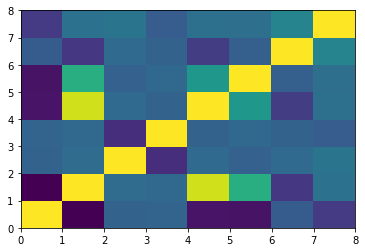

In [12]:
plt.pcolor(cor)
plt.show()

In [13]:
import seaborn as sns

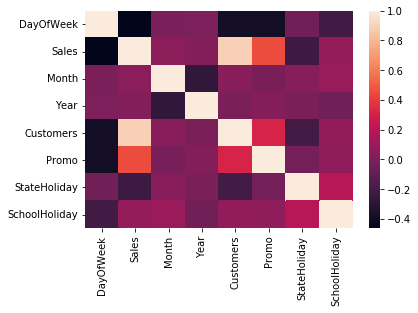

In [14]:
sns.heatmap(data=cor)
plt.show()

In [20]:
print("NANs მაღაზიის მონაცემებშის თითოეულ სვეტში")
print("---------------------------")
from collections import Counter
x = {colname : df_store[colname].isnull().sum() for colname in df_store.columns}
Counter(x).most_common()

NANs მაღაზიის მონაცემებშის თითოეულ სვეტში
---------------------------


[('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('CompetitionDistance', 0),
 ('CompetitionOpenSinceMonth', 0),
 ('CompetitionOpenSinceYear', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [16]:
df_store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [17]:
df_store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [18]:
df_store['Promo2SinceWeek'].fillna(0, inplace=True)
df_store['Promo2SinceYear'].fillna(0, inplace=True)
df_store['CompetitionOpenSinceYear'].fillna(df_store['CompetitionOpenSinceYear'].median(), inplace=True)
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].mean(), inplace=True)
df_store['CompetitionOpenSinceMonth'].fillna(7.224, inplace=True)
df_store['CompetitionOpenSinceMonth'].mean()
df_store['PromoInterval'].fillna(0, inplace=True)

In [19]:
df_store.PromoInterval.value_counts()

0                   544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_store['PromoInterval'] = le.fit_transform(df_store['PromoInterval'].astype(str))
df_store['StoreType'] = le.fit_transform(df_store['StoreType'].astype(str))
df_store['Assortment'] = le.fit_transform(df_store['Assortment'].astype(str))

გადავაბათ ერთმანეთს გაყიდვების და მარაზიების მონაცემები, რომ მივიღოთ ერთიანი მონაცემები მოდელირებისთვის:

In [22]:
df_main=pd.merge(df, df_store, how='left', on='Store')

In [24]:
df_main.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0


In [25]:
df_main.shape

(1017209, 20)

In [26]:
df_main.isna().sum().sum()

0

C:\Users\George Ch\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


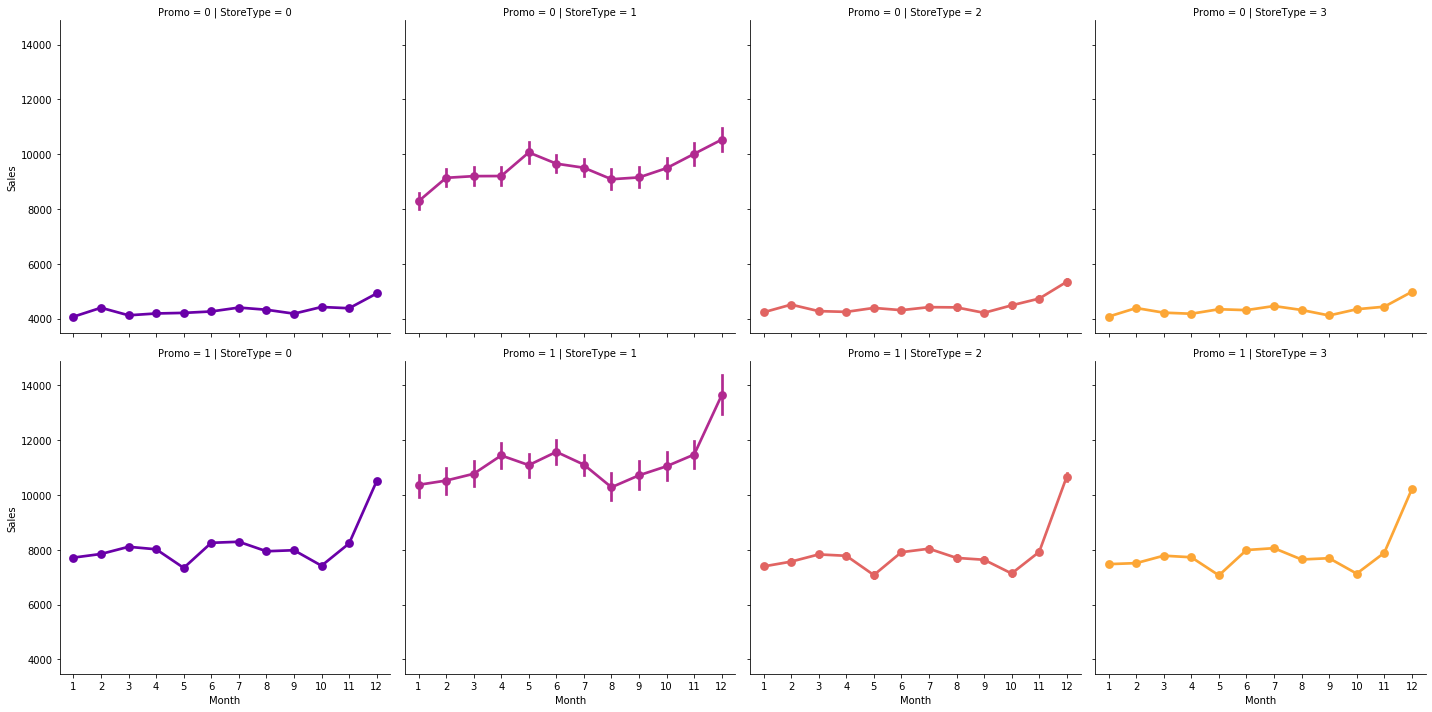

In [29]:
sns.factorplot(data = df_main, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

C:\Users\George Ch\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


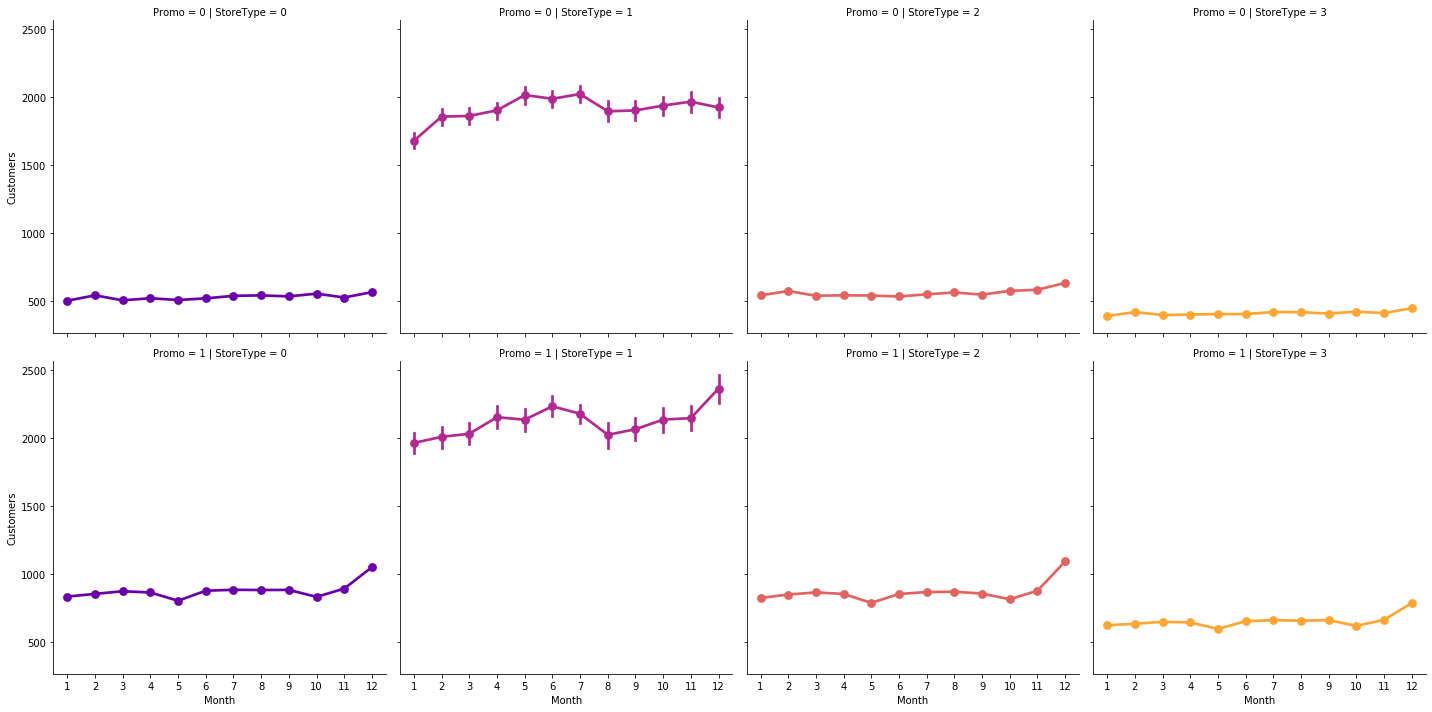

In [30]:
sns.factorplot(data = df_main, x = 'Month', y = "Customers", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

C:\Users\George Ch\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


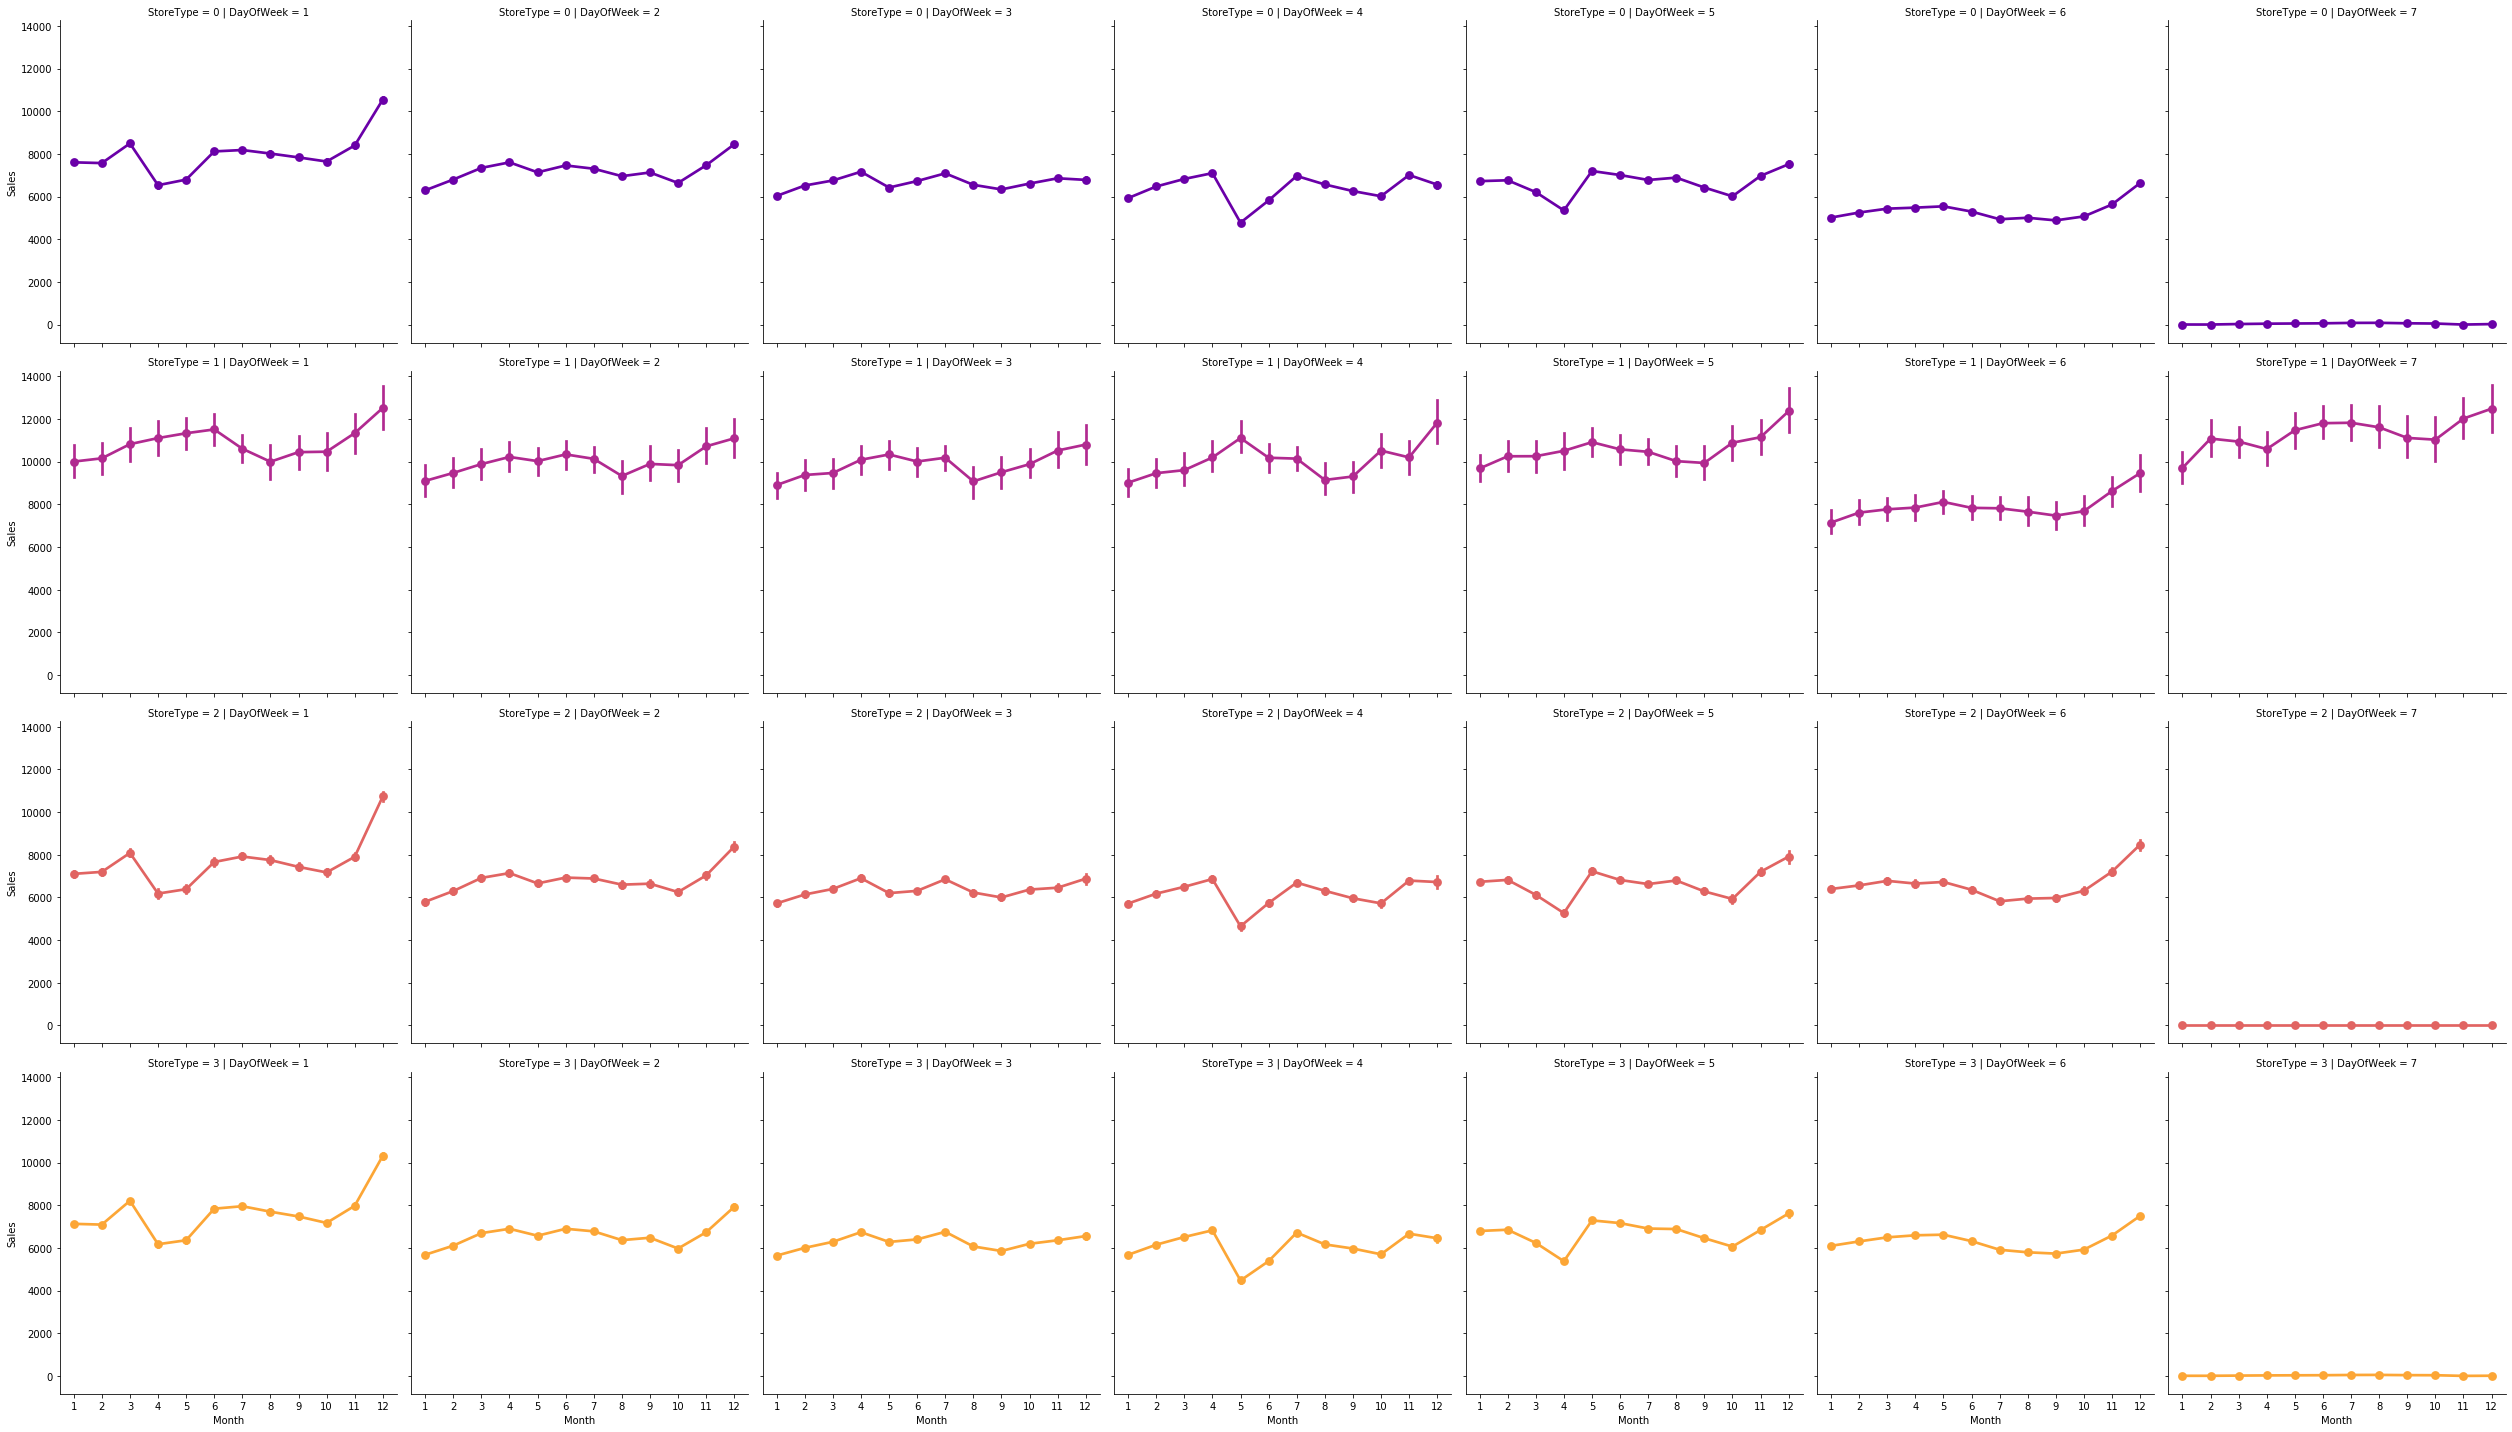

In [31]:
sns.factorplot(data = df_main, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType') 

C:\Users\George Ch\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


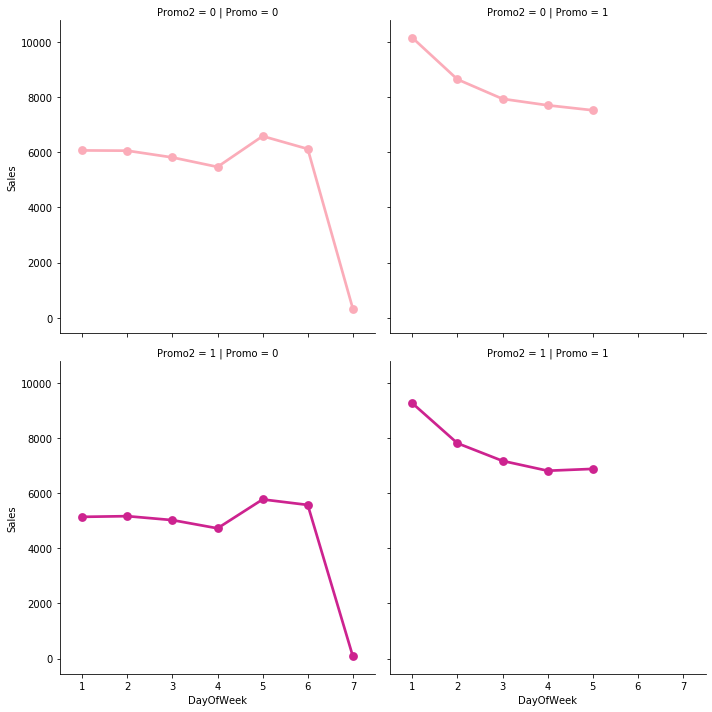

In [32]:
sns.factorplot(data = df_main, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

განსხვავებით ისეთ მონაცემებისა სადაც დროითი ცვლადის მიხედვით არ გვაქვს პროცესის დინამიკა, და მომავალ დროში გვურს რომ ვიპროგნოზოთ, მონაცემების გახლეჩვას რანდომულად ვერ მოვახდენთ, ასეთ შემთხვევაში ჩვენ საწვრთნელი და სატესტო მონაცემები უნდა გავხლიჩოთ დროის მიხედვით, ვინდაიდან ვინდა ავაგოთ ისეთ მოდელი რომელიც ისწავლის წარსულზე და იპროგნოზებს მომავალს.

In [33]:
#ჩვენი მონაცემების დროის დიაპაზონი
df1 = df_main[['Date','Sales']].agg(['min','max'])
print (df1)

           Date  Sales
min  2013-01-01      0
max  2015-07-31  41551


In [49]:
df_tr = df_main.loc[df_main['Date'] <= '2015-01-01']
df_tst = df_main.loc[df_main['Date'] > '2015-01-01']

In [50]:
df_train = df_tr.loc[df_tr['Date'] <= '2014-05-01']
df_val = df_tr.loc[df_tr['Date'] > '2014-05-01']

In [51]:
df_train.drop('Date', axis=1, inplace=True)
df_val.drop('Date', axis=1, inplace=True)
df_tst.drop('Date', axis=1, inplace=True)

C:\Users\George Ch\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
x_tr = df_train.drop(columns='Sales')
y_tr = df_train['Sales'] 

x_val = df_val.drop(columns='Sales')
y_val = df_val['Sales'] 

x_tst = df_tst.drop(columns='Sales')
y_tst = df_tst['Sales'] 

In [53]:
from xgboost import XGBRegressor

In [54]:
model = XGBRegressor()

In [55]:
model.fit(x_tr ,y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
y_pred=model.predict(x_val)

In [57]:
print(model.score(x_val, y_val))

0.8762472601726832


In [58]:
print(model.score(x_tr, y_tr))

0.9083744608593409


In [60]:
y_pred_test=model.predict(x_tst)

In [59]:
print(model.score(x_tst, y_tst))

0.8858151349178336


In [48]:
df_main.drop('Customers', axis=1, inplace=True)